# runge-kutta integration for multiple coupled variables

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def dydx(x, y):

    #define coupled derivatives to integrate

    #our equation is d^2y/dx^2 = -y

    #we can write dydx = z, dzdx = -y

    #set y = y[0]
    #set z = y[1]

    #declare an array
    y_derivs = np.zeros(2)

    #set dydx = z
    y_derivs[0] = y[1]

    #set dzdx = -y
    y_derivs[1] = -1*y[0]

    #return an array
    return y_derivs


# Define 4th order RK method

In [38]:
def rk4_mv_core(dydx, xi, yi, nv, h):
    
    #declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    #define x at 1/2 step
    x_ipoh = xi + 0.5*h
    
    #define x at 1 step
    x_ipo = xi + h
    
    #declare a temp y array
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k4[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return yipo

# Define an adaptive step size driver for RK4 

In [39]:
def rk4_mv_ad(dydx, x_i, y_i, nv, h, tol):
    
    #define saftey scale
    SAFTEY = 0.9
    H_NEW_FAC = 2.0
    
    #set max number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv, 2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        #estimate our error by taking one step of size h vs two steps of size h/2
        y_2 = rk4_mv_core(dydx, x_i, y_i, nv, h_step)
        y_1 = rk4_mv_core(dydx, x_i, y_i, nv, 0.5*h_step)
        y_11 = rk4_mv_core(dydx, x_i+0.5*h_step, y_i, nv, 0.5*h_step)
        
        #compute an error
        Delta = np.fabs(y_2 - y_11)
        
        #if the error is too large, take a smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFTEY * (Delta.max()/tol)**(-0.25)
            
        #check iteration
        if(i>=imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ", i)
            
        #iterate
        i += 1
        
    #next time, try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
        
    #return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

# Define a wrapper for RK4

In [40]:
def rk4_mv(dydx, a, b, y_a, tol):
    #dydx is the derivative w/r to x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    #set the max number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #set the number of coupled ODE's to the size of y_a
    nv = len(y_a)
    
    #set the initial conditions
    x = np.full(1, a)
    y = np.full((1, nv), y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+!
            yi_new, h_new, h_step, = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
            
            #break
            flag = 0
        
        #update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x, xi)
        y_new = np.zeros((len(x), nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too many iteration
        if(i>imax):
            
            print("Maximum iterations reached")
            raise StopIteration("Iteration number = ", i)
            
            #iterate
            i += 1
            
            #output some  information
            s = "i = %3d/tx = %9.8f/th = %9.8/tb=%9.8f" % (i, xi, h_step, b)
            print(s)
            
            #break if new xi is == b
            if(xi==b):
                flag = 0
                
        return x,y
        

In [41]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perfrom the integration
x,y = rk4_mv(dydx, a, b, y_0, tolerance)

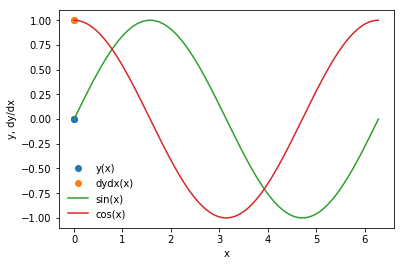

In [42]:
plt.plot(x,y[:,0], 'o', label='y(x)')
plt.plot(x,y[:,1], 'o', label='dydx(x)')
xx = np.linspace(0,2.0*np.pi, 1000)
plt.plot(xx, np.sin(xx), label='sin(x)')
plt.plot(xx, np.cos(xx), label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

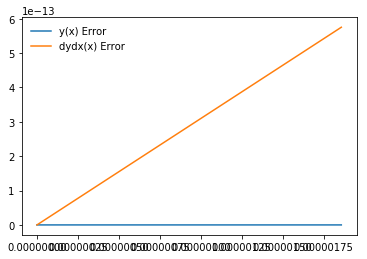

In [43]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label="y(x) Error")
plt.plot(x, dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)